In [1]:
"""
scaled dimensions
1x  = (3384,3481,3481)
2x  = (1692,1740,1740)
4x  = (846,870,870)
8x  = (423,435,435)
16x = (211,217,217)

each original subvolume has dimensions:
s1 = (846,3484,3484)
s2 = (846,3484,3484)
s3 = (846,3493,3493)
s4 = (846,3481,3481)
lowest yz-dimensions gives full volume dimensions:
(846*4,3481,3481)
# example of fitting last two dimensions
# first we fix yz-plane since individual lengths of dimensions may differ a little per sample
# quick analysis shows they are not shifted but rather padded, so removal is easy
if topvol.shape[1:] != botvol.shape[1:]: # last to dimensions are not equal
    y_min = np.min([topvol.shape[1],botvol.shape[1]])
    z_min = np.min([topvol.shape[2],botvol.shape[2]])
    topvol[:,:y_min,:z_min]
    botvol[:,:y_min,:z_min]
"""

#:TODO - shadow effects could perhaps be removed by histogram matching of final adjacent regions

#############################
### Fix staggered volumes ###
#############################

'\nscaled dimensions\n1x  = (3384,3481,3481)\n2x  = (1692,1740,1740)\n4x  = (846,870,870)\n8x  = (423,435,435)\n16x = (211,217,217)\n\neach original subvolume has dimensions:\ns1 = (846,3484,3484)\ns2 = (846,3484,3484)\ns3 = (846,3493,3493)\ns4 = (846,3481,3481)\nlowest yz-dimensions gives full volume dimensions:\n(846*4,3481,3481)\n# example of fitting last two dimensions\n# first we fix yz-plane since individual lengths of dimensions may differ a little per sample\n# quick analysis shows they are not shifted but rather padded, so removal is easy\nif topvol.shape[1:] != botvol.shape[1:]: # last to dimensions are not equal\n    y_min = np.min([topvol.shape[1],botvol.shape[1]])\n    z_min = np.min([topvol.shape[2],botvol.shape[2]])\n    topvol[:,:y_min,:z_min]\n    botvol[:,:y_min,:z_min]\n'

In [2]:
import h5py
import numpy as np
#path_4x = '/home/jovyan/work/Avery/MAXIBONE/Goats/tomograms/hdf5-byte/scale/4x/'
path = '/mnt/data/MAXIBONE/Goats/tomograms/hdf5-byte/scale/'
seg_path ='/mnt/data/MAXIBONE/Workspace/Mads/Concatenated_1x_samples/'

In [3]:
samples_1x = ['769.h5','769c.h5','770.h5', '770c.h5','771.h5', '771c.h5', '772.h5',\
              '774.h5','775.h5', '775c.h5','778.h5', '778c.h5','780c.h5', '785c.h5',\
              '788c.h5','810.h5','810c.h5','811.h5','815.h5','819.h5']
samples = ['769c.h5','770c.h5','771c.h5', '772.h5','774.h5','775.h5','778c.h5',\
          '780c.h5','785c.h5', '788c.h5','810c.h5','811.h5','815.h5','819.h5']

In [4]:
def extract_chunks(arr, overlap, niter):
    """
    extract elements from list in chuncks of length=overlap WITH overlap
    in order to not spend too much ram, we only load what we need each time when comparing
    """
    # arr     : segment of bottom volume rows to split into chunks for comparing euclidean distance with lowest part of top volume
    # overlap : defines number of rows to look at simultanously, also equal to number of rows in top volume
    # niter   : how many chunks to look through in bottom volume, i.e. how far to search for best overlap
    return [arr[i : i + int(overlap),:,:] for i in range(0, int(niter), 1)]

def minDist(top, bot_chunks):
    # subtract volume slices pixelwise, square the values, divide by number of voxels, argmin gives best match = smallest difference
    c = np.array([bot_chunks[i]-top for i in range(len(bot_chunks))])**2 # dim: (n-iter, overlap, y, z)
    return np.argmin(np.sqrt(np.squeeze(np.apply_over_axes(np.sum, c, [1,2,3])/(int(c.shape[1]*c.shape[2])))))

def match_region(hfpath,scale,crossing,overlap,region):

    """
    hfpath   : path to full volume hdf5
    scale    : which scaling to use
    crossing : number between [1-3] which determines the overlapping region
    overlap  : depth of each chunk -- this puts a boundary on smallest detectable volume shift
               - i.e. when overlap matches in iteration 0, we must shift by size of overlap
    region   : search region, i.e. how many chunks of planes to iterate through, or how far to look/compare
    """

    dex =  {'1' : [846, 1692, 2538, 3384],
            '2' : [423,  846, 1269, 1692],
            '4' : [212,  423,  635,  846],
            '8' : [106,  212,  318,  423],
            '16': [ 53,  106,  159,  211]}

    with h5py.File(str(hfpath), 'r') as hf:

        # mapping from crossing to dex
        # a = upper idx, b = middle idx, c = lower idx
        if crossing == 1:
            a = 0
            b = dex[str(scale)][0]
            #c = dex[str(scale)][1] # not needed
        elif crossing == 2:
            a = dex[str(scale)][0]
            b = dex[str(scale)][1]
            #c = dex[str(scale)][2] # not needed
        elif crossing == 3:
            a = dex[str(scale)][1]
            b = dex[str(scale)][2]
            #c = dex[str(scale)][3] # not needed
        
        # load only last part of top volume, which is used for comparison
        topvol = hf['voxels'][a:b,:,:][-overlap:,:,:]
        # load only top part of bottom volume, which is iterated through for comparison
        botvol = hf['voxels'][b:,:,:][:region,:,:]
        # split bottom volume into overlapping chunks for vectorised comparison
        botvol_chunks = extract_chunks(botvol, overlap=overlap, niter=region)

        # find index of smallest difference from euclidean distance between overlaps
        # an overlap of 2 has shown to work better than 1, the difference becomes larger and the result more consistant and robust to fluctuations
        shift_idx = minDist(topvol, botvol_chunks)+overlap # adding overlap because when idx=0 this means we shift by "depth of overlap"
    
    return shift_idx

def concat_volumes(hfpath, scale, shift_idxs,sample):

    dex =  {'1' : [846, 1692, 2538, 3384],
            '2' : [423,  846, 1269, 1692],
            '4' : [212,  423,  635,  846],
            '8' : [106,  212,  318,  423],
            '16': [ 53,  106,  159,  211]}
    
    a,b,c,d = dex[str(scale)]

    fname = str(scale)+'x_' + sample[:-3] + '_concat.h5'
    with h5py.File(fname, 'a') as fout:

        for i in range(len(shift_idxs)):

            # left : accumulated ... right : from b:c-idx
            if i == 0:

                with h5py.File(hfpath, 'r') as fsrc:

                    full_dim = fsrc['voxels'].shape
                    new_dim = tuple(np.subtract(full_dim, (np.sum(shift_idxs),0,0)))

                    newf = fout.create_dataset(name='voxels', shape=new_dim, dtype=np.uint8, compression='gzip', compression_opts=4)

                    # 1/4
                    newf[:a-shift_idxs[i],:,:] = fsrc['voxels'][:a-shift_idxs[i],:,:]
            
            if i == 1:

                with h5py.File(hfpath, 'r') as fsrc:

                    # 2/4
                    newf[a-shift_idxs[i-1]:b-np.sum(shift_idxs[:2]),:,:]= fsrc['voxels'][a:b-shift_idxs[i],:,:]

            if i == 2:

                with h5py.File(hfpath, 'r') as fsrc:

                    # 3/4
                    newf[b-np.sum(shift_idxs[:2]):c-np.sum(shift_idxs[:3]),:,:] = fsrc['voxels'][b:c-shift_idxs[i],:,:]

                    # 4/4
                    newf[c-np.sum(shift_idxs[:3]):,:,:] = fsrc['voxels'][c:d,:,:]

    print('Finished concatenating new volume: {}.'.format(fname))

    return

In [30]:
""" Run functions """

# loop through all 3 crossings in full volume --- can be vectorized, but for easy control, it has been seperated, it runs fast enough
#for cats in range(8,len(samples_1x)):
scale_factor = 4
overlap = 2
search_region = 20

shift_sample = samples[13]
print(shift_sample)

shift_indices = []
for i in range(1,3+1):
    shift_indices.append(match_region(hfpath = path  + str(scale_factor) +'x/' + shift_sample, scale=scale_factor,crossing=i,overlap=overlap,region=search_region))

    print('shift indices:', shift_indices)

concat_volumes(hfpath = path  + str(scale_factor)+'x/' + shift_sample, scale=scale_factor, shift_idxs=shift_indices, sample = shift_sample)

    # -------------------------------------------------------------------- #

819.h5
shift indices: [2]
shift indices: [2, 2]
shift indices: [2, 2, 2]


RuntimeError: Unable to create link (name already exists)

In [ ]:
import numpy as np

""" improvement and generalization of dynamic overlap-index matrix """

# starting point is either a file per subvolume (easier to optimize)
# or a concatenated volume in a single file (as here in the downscaled h5 files)

# dex =  {'1' : [846, 1692, 2538, 3384],
#         '2' : [423,  846, 1269, 1692],
#         '4' : [212,  423,  635,  846],  # (rounded 211.5 up, due to shadow effect)
#         '8' : [106,  212,  318,  423],  # (rounded 105.75 up, due to shadow effect, 424 is rounded down to max: 423, but ok in python)
#         '16': [ 53,  106,  159,  211]}  # (212 is rounded down to max: 211, but ok in python)

# # this can be generalized to:

# S = 3384 # full_volume.shape[0] # taken directly from shape of input hdf5 file

# def w(x):
#     # in order to use as index we round and typecast as integer
#     return int(np.ceil(x))

# dex = {'1' : [w(S/4),  w(S/2),   w(3*S/4), w(S)],
#        '2' : [w(S/8),  w(S/4),   w(3*S/8), w(S/2)],
#        '4' : [w(S/16), w(S/8),  w(3*S/16), w(S/4)],
#        '8' : [w(S/32), w(S/16), w(3*S/32), w(S/8)],
#        '16': [w(S/64), w(S/32), w(3*S/64), w(S/16)]}

1x_819_concat.h5
819.h5


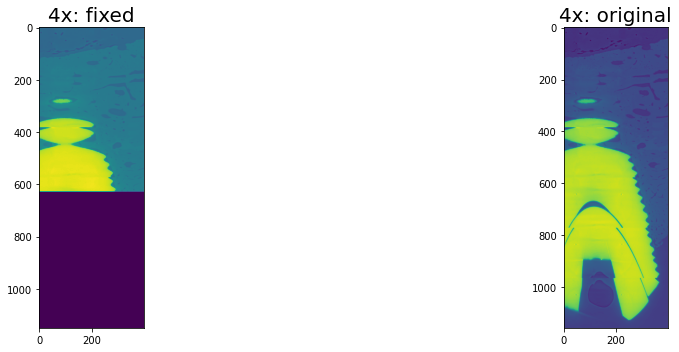

In [31]:
""" verify that it works """


import numpy as np
import matplotlib.pyplot as plt
import h5py

shift_sample =  samples[13]


print('1x_' + shift_sample[:-3] + '_concat.h5')
print(shift_sample)

# %matplotlib qt

with h5py.File(f'4x_{shift_sample[:-3]}_concat.h5', 'r') as hg:
     data_fixed = hg['voxels'][:,300:700,400]

with h5py.File(path+ '4x/' + shift_sample, 'r') as hf:
     data = hf['voxels'][:,300:700,400]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
ax[0].imshow(data_fixed); ax[0].set_title('4x: fixed', fontsize=20)
ax[1].imshow(data); ax[1].set_title('4x: original', fontsize=20)
#ax[2].imshow(fix_altered[180:220,400:490]); ax[2].set_title('4x: hist matching', fontsize=20)
plt.tight_layout()
#plt.savefig('4x_example1.png', facecolor='w', bbox_inches='tight', pad_inches=0)
plt.show()

